# <img src="./assets/course-icon.png" style="height:50px;display:inline"> Deep Learning
---

create by Arwin Yu

## Tutorial 07 - Denoising Diffusion Probabilistic Models (DDPM) 
---
<center><img src="./assets/ddpm1.png" style="height:400px"></center>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* 扩散模型的基本原理
* 前向扩散
* 损失函数与训练
* 反向去噪
    * 生成模型总体框架
    * VAE的变分下界
    * DDPM的变分下界
* Demo：生成瑞士卷

## <img src="https://img.icons8.com/cute-clipart/64/000000/alarm.png" style="height:50px;display:inline"> 扩散模型的基本原理
---
Denoising Diffusion Probabilistic Models (DDPM) 是一种利用扩散过程来生成样本的深度学习模型。其主要的灵感来源于扩散过程，通过逐渐增加噪音来模糊一个初始的图像，并通过学习一个去噪模型来逆向回到原始图像。这种方法为高质量的样本生成和变换提供了一种新颖的视角。

扩散模型主要概念和步骤如下：

1. 添加噪声：模型从一张真实的图像开始，然后逐步增加噪声。在这个过程中，图像的细节和结构逐渐被噪声所覆盖，最终转变成随机噪声。
2. 逆向过程：在生成过程中，模型执行与添加噪声相反的操作。它从噪声图像开始，逐步去除噪声并恢复图像的结构和细节。这个过程是通过训练模型来学习如何从噪声图像中逐步恢复出原始图像来实现的。
3. 训练过程：模型通过大量的真实图像及其噪声版本进行训练。它学习如何预测在添加噪声的过程中丢失的图像信息，从而能够在生成过程中逐步重建图像。
4. 控制生成：在模型训练完成后，可以利用它来生成新的图像。这通常是通过提供一个含有噪声的起始图像和一些指导条件（如文本描述）来实现的。模型然后根据这些条件去除噪声，生成与条件匹配的图像。

<center><img src="./assets/g10.png" style="height:600px"></center>


## <img src="https://img.icons8.com/?size=100&id=71044&format=png&color=000000" style="height:50px;display:inline"> DDPM 前向扩散
---
在扩散模型中，噪声注入的基本思想是通过加入随机噪声，使得数据的分布进行变化，使得模型在训练时需要适应这些变化，从而可以提高模型的泛化能力。

扩散模型中噪声注入的具体过程通常如下：

假设我们有一个图片数据集的概率分布 $P(x)$, 我们想要模型学习这个分布。

在扩散模型中, 我们不直接对 $P(x)$ 建模, 而是对一个由 $P(x)$ 通过扩散过程得到的分布 $q\left(x^{\prime}\right)$ 建模。

这个扩散过程可以看作是向 $P(x)$ 中注入噪声。

对于每一个数据点 $x$, 我们可以通过以下方式进行噪声注入:

* 选取一个噪声分布, 例如高斯噪声分布 $N\left(0, \sigma^2\right)$ 。
* 从这个噪声分布中采样出噪声 $\varepsilon$, 并将其加入到数据点 $x$ 中, 得到新的数据点 $x^{\prime}$ 。即:$x^{\prime}=x+\varepsilon \text {, 其中 } \varepsilon \sim N\left(0, \sigma^2\right)$
* 这就是扩散模型中噪声注入的基本过程。在这个过程中, $\sigma$ 控制了噪声的强度。 $\sigma$ 越大,噪声越强, 数据点 $x^{\prime}$ 与原始数据点 $x$ 的差距越大。

在实际应用中, 这个过程通常会被重复多次, 每次注入的噪声可以相同, 也可以不同。例如, 我们可以在每一步中逐渐增大 $\sigma$, 使得噪声逐渐增强。当加上时间概念对加噪过程进行数学描述时，公式如下：

$$
q\left(x_{1: T} \mid x_0\right)=\prod_{t \geq 0} q\left(x_t \mid x_{t-1}\right), \quad q\left(x_t \mid x_{t-1}\right)=N\left(x_t ; \sqrt{1-\beta_t} x_{t-1}, \beta_t I\right)
$$

解释一下上述公式, 我们考虑一个随时间变化的数据序列 $x_0, x_1, \ldots, x_T$, 其中 $x_0$ 是原始数据, $x_{1: T}$ 是在一系列噪声扩散过程后得到的数据。

* 对于任意的 $t, q\left(x_t \mid x_{t-1}\right)$ 表示在给定 $x_{t-1}$的情况下 $x_t$ 的条件概率分布。

* 在这里, 这个分布被定义为一个高斯分布, 其均值是 $1-\beta_t x_{t-1}$,方差是 $\beta_t I$ 。其中 $I$ 是单位矩阵, 表示的是每个维度上的噪声是独立的。这个高斯分布就代表了在时间 $t$ 所注入的噪声。

* $N\left(x_t ; \sqrt{1-\beta_t} x_{t-1}, \beta_t I\right)$ 表示当前步骤的图像状态 $x_t$ 是从一个以 $\sqrt{1-\beta_t} x_{t-1}$ 为均值、 $\beta_t I$ 为方差的正态分布中采样得到的。这里, $\beta_t$ 是一个预先定义的噪声级别参数, 用于控制每一步添加的噪声量。


* 其中, $\beta_t$ 是一个介于 0 和 1 之间的参数, 控制了噪声注入的强度。具体来说, $1-\beta_t$ 是噪声注入前的数据所占比重, 而 $\beta_t$ 是噪声的方差。

* 因此, 当 $\beta_t$ 接近 0 时, 噪声的影响较小, $x_t$ 主要由 $x_{t-1}$ 决定; 当 $\beta_t$ 接近 1 时, 噪声的影响较大, $x_t$ 更多地由噪声决定。

实际上，这个**加噪的过程就是一个马尔可夫链算法**，在马尔可夫链中，一个状态的下一状态只依赖于当前状态，而与过去的状态无关，这就是所谓的“无记忆性”。

对于给定的公式：
$$
q\left(x_{1: T} \mid x_0\right)=\prod_{t \geq 0} q\left(x_t \mid x_{t-1}\right)
$$
其中, $x_{t-1}$ 是前一个状态, $x_t$ 是下一个状态, 公式表明下一个状态 $x_t$ 只依赖于前一个状态 $x_{t-1}$ 。所以, 整个序列 $x_0, x_1, \ldots, x_T$ 实际上构成了一个马尔可夫链。

此外,
$$
q\left(x_t \mid x_{t-1}\right)=N\left(x_t ; \sqrt{1-\beta_t} x_{t-1}, \beta_t I\right)
$$

公式表示了在给定前一个状态 $x_{t-1}$ 的情况下, 下一个状态 $x_t$ 的概率分布。这实际上是马尔可夫链中的状态转移概率。

所以，从这个角度看，这个公式实际上描述了一个马尔可夫链，并且这个马尔可夫链的状态转移概率是高斯分布。这样的马尔可夫链也被称为高斯马尔可夫链。

值得注意的是，我们每次进行噪声加入的时候都是很有规矩的加入一定的高斯噪声，那我们是否可以打破这种循规蹈矩，不用多次的加入而是**一步到位**呢？

**前向加噪过程的简化**

---

在原论文已经给出了相关的推导, 论文中给到的公式是 $x_t=\sqrt{\bar{\alpha}_t} x_0+\sqrt{1-\bar{\alpha}_t} \epsilon$, 这个公式与上文推导的公式 $q\left(x_t \mid x_{t-1}\right)=N\left(x_t ; \sqrt{1-\beta_t} x_{t-1}, \beta_t I\right)$ 最大的不一样在于 $x_t$ 的生成不依赖于 $x_{t-1}$, 而是根据初始图片 $x_0$ 和扩散次数 $t$ 即可生成, 

换句话说, 原论文中给出的公式允许一步到位生成噪声图片, 而不需要多次的迭代叠加噪声, 这大大的简化的生成噪声图片的流程。

这个公式的推导要依赖于重参数化技巧, 下面进行详细的数学推导。

重参数化是一种用于训练深度概率模型的策略, 在变分自编码器 (VAE) 和扩散模型中经常使用。考虑一个基本的噪声注入过程: 我们有一个数据点 $x$, 我们想要向其注入服从高斯分布 $N\left(0, \sigma^2\right)$ 的噪声。如果我们直接从这个分布中采样噪声 $\varepsilon$, 并将其加到 $x$ 上, 那么这个过程就涉及到随机性, 无法直接进行反向传播。

为了解决这个问题, 我们可以使用重参数化技巧。具体来说, 我们不是直接从 $N\left(0, \sigma^2\right)$中采样噪声, 而是先从标准正态分布 $N(0, I)$ 中采样, 然后再通过适当的变换得到我们想要的噪声。这样, 这个噪声注入过程就可以分解为两步:

(1) 从标准正态分布 $N(0, I)$ 中采样噪声 $\boldsymbol{\varepsilon}$ 。

(2) 将噪声 $\boldsymbol{\varepsilon}$ 进行变换, 得到我们想要的噪声 $\varepsilon=\sigma \varepsilon^2$ 。

然后, 我们就可以将这个噪声 $\varepsilon$ 加到数据点 $x$ 上, 得到新的数据点 $x^{\prime}=x+\varepsilon$ 。

通过这种方式, 我们就将噪声注入过程中的随机性移到了第一步, 这一步是可以进行反向传播的。因为标准正态分布 $N(0, I)$ 是固定的, 不涉及到模型的参数, 所以从中采样的过程是可以进行反向传播的。

然后, 第二步中的变换也是可以进行反向传播的, 因为这个变换只涉及到乘法和加法, 这两种操作都是可导的。这样, 整个噪声注入过程就可以进行反向传播, 可以被优化。这就是重参数化技巧。

**为什么噪声为什么不直接从标准正态分布中采样？还要经过变换？**

在实际应用中，我们通常需要从**不同尺度**的正态分布中采样噪声（即具有不同方差的分布）。通过变换标准正态分布的噪声，我们可以轻松地生成符合不同尺度的噪声，而不需要直接采样不同的正态分布。

在扩散模型中, 这种技巧也被广泛使用。

* 我们可以先从标准正态分布 $N(0, I)$ 中采样噪声 $\varepsilon$, 然后将这个噪声通过变换 $\varepsilon=\beta_t \varepsilon^{\prime}$,得到我们想要的噪声。
* 然后再将这个噪声加到 $x_{t-1}$ 上, 得到新的数据点:
$$
x_t=\sqrt{1-\beta_t} x_{t-1}+\sqrt{\beta_t} \varepsilon_{t-1}
$$

在上述公式中:

*  $x_t$ 是在时间步 $t$ 的状态; $\beta_t$ 是一个介于 0 和 1 之间的参数, 控制着前一个状态 $x_{t-1}$ 和新引入的噪声 $\varepsilon_{t-1}$ 对当前状态 $x_t$ 的贡献。
* $\varepsilon_t$ 是噪声项, 通常假定服从标准正态分布, 表示在时间 $t$ 引入的随机噪声。
* 在实践中, $\beta_t$ 通常是预先定义的, 可以根据特定的扩散过程进行设定。

**继续推导下去**

* 令 $\alpha_t=1-\beta_t, \bar{\alpha}_i=\prod_{s=0}^t \alpha_s, \epsilon_0, \epsilon_1, \ldots, \epsilon_{t-2}, \epsilon_{t-1} \sim \mathcal{N}(0, I)$
* 对于 $x_t$,我们可以将其写为: $x_t=\sqrt{\alpha_i} x_{t-1}+\sqrt{1-\alpha_t} \epsilon_{t-1}$
* 然后, 我们将 $x_{t-1}$ 进一步展开:
$$
x_{t-1}=\sqrt{\alpha_{t-1}} x_{t-2}+\sqrt{1-\alpha_{t-1}} \epsilon_{t-2}
$$

现在, 我们将这个表达式代入到 $x_t$ 的公式中:
$$
x_t=\sqrt{\alpha_t}\left(\sqrt{\alpha_{t-1}} x_{t-2}+\sqrt{1-\alpha_{t-1}} \epsilon_{t-1}\right)+\sqrt{1-\alpha_t} \epsilon_{t-1}
$$

可以整理为:
$$
x_t=\sqrt{\alpha_t \alpha_{t-1}} x_{t-2}+\sqrt{\alpha_t\left(1-\alpha_{t-1}\right)} \epsilon_{t-2}+\sqrt{1-\alpha_t} \epsilon_{t-1} .
$$
由于 $\epsilon_{t-2}$ 和 $\epsilon_{t-1}$ 都是独立的高斯随机变量, 我们可以将这两项合并, 得到:
$$
\begin{aligned}
& \sqrt{\alpha_t \alpha_{t-1}} x_{t-2}+\sqrt{\alpha_t\left(1-\alpha_{t-1}\right)} \epsilon+\sqrt{1-\alpha_t} \epsilon \\
& =\sqrt{\alpha_t \alpha_{t-1}} x_{t-2}+\mathcal{N}\left(0, \alpha_t\left(1-\alpha_{t-1}\right)\right)+\mathcal{N}\left(0,1-\alpha_t\right) \\
& =\sqrt{\alpha_t \alpha_{t-1}} x_{t-2}+\mathcal{N}\left(0,1-\alpha_t \alpha_{t-1}\right) \\
& =\sqrt{\alpha_t \alpha_{t-1}} x_{t-2}+\sqrt{1-\alpha_t \alpha_{t-1}} \epsilon^{\prime}
\end{aligned}
$$
其中 $\epsilon^{\prime}$ 是新的随机噪声, 其分布为 $\mathcal{N}(0, I)$ 。然后, 我们可以继续这个过程, 将 $x_{t-2}$ 继续展开,直到 $x_0$ 。最后我们会得到:
$$
x_t=\sqrt{\bar{\alpha}_t} x_0+\sqrt{1-\bar{\alpha}_t} \epsilon^{\prime \prime}
$$

其中 $\epsilon^{\prime \prime}$ 也是随机噪声, 分布为 $\mathcal{N}(0, I)$ 。
最后, 由于 $x_t$ 是 $x_0$ 和随机噪声 $\epsilon^{\prime \prime}$ 的线性组合, 因此 $x_t$ 的分布为正态分布
$$
N\left(\sqrt{\alpha_t} x_0,\left(1-\bar{\alpha}_t\right) I\right)
$$

**通过这种方法，可以直接计算出任意时间点的噪声图像，而无需逐步通过每个噪声级别。这在理论上简化了加噪过程，并使得在生成和处理数据时更加高效。**

### <img src="https://img.icons8.com/?size=100&id=48250&format=png&color=000000" style="height:50px;display:inline"> 前向扩散代码示例

DDPM 前向过程如下:
$$
q_\sigma\left(\mathbf{x}_t \mid \mathbf{x}_0\right)=\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t \epsilon}
$$

式中， $\bar{\alpha}_t=\prod_{i=1}^T\left(1-\beta_i\right) ， \bar{\alpha}_t$ 计算方法如下:

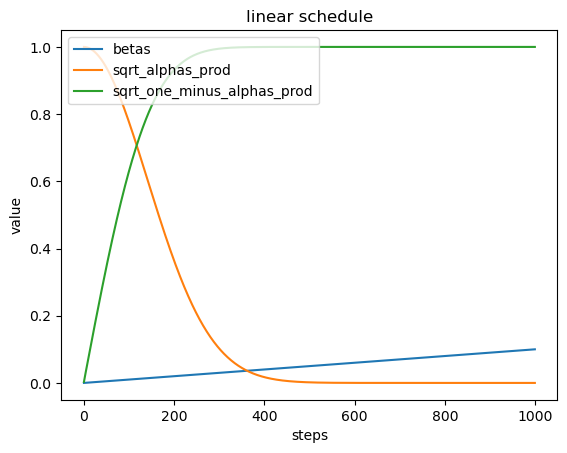

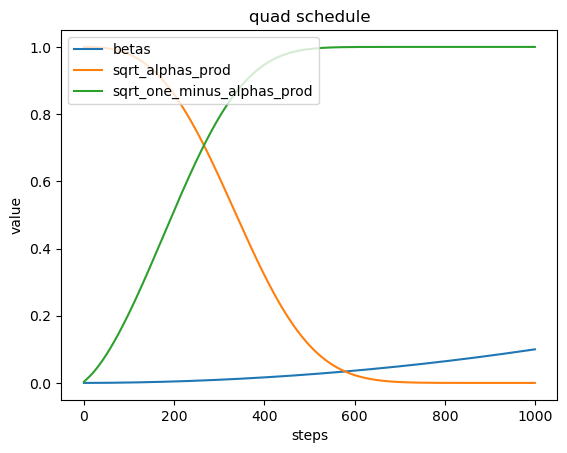

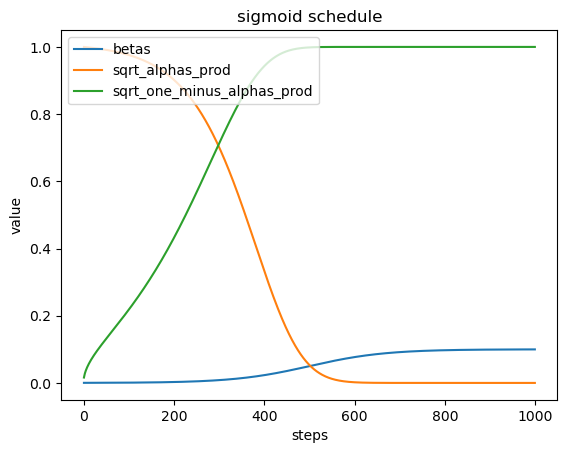

In [10]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 生成beta参数的调度表
# schedule: 调度类型（'linear', 'quad', 'sigmoid'）
# n_timesteps: 总的时间步数
# start: beta的起始值
# end: beta的结束值
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


# 绘制不同调度类型的beta参数和相关参数随时间步的变化曲线
# n_steps: 总的时间步数
# schedule: 调度类型
def plot_schedule(n_steps,schedule):
    plt.plot(list(range(n_steps)),betas.numpy(),label='betas')
    plt.plot(list(range(n_steps)),torch.sqrt(alphas_prod).numpy(),label='sqrt_alphas_prod')
    plt.plot(list(range(n_steps)),torch.sqrt(1-alphas_prod).numpy(),label='sqrt_one_minus_alphas_prod')
    plt.legend(['betas','sqrt_alphas_prod','sqrt_one_minus_alphas_prod'],loc = 'upper left')
    plt.xlabel('steps')
    plt.ylabel('value')
    plt.title('{} schedule'.format(schedule))
    plt.show()

# 设置时间步数
n_steps = 1000

# 线性调度
schedule = 'linear'
betas = make_beta_schedule(schedule=schedule, n_timesteps=n_steps, start=1e-5, end=1e-1)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
plot_schedule(n_steps, schedule)

# 二次方调度
schedule = 'quad'
betas = make_beta_schedule(schedule=schedule, n_timesteps=n_steps, start=1e-5, end=1e-1)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
plot_schedule(n_steps, schedule)

# Sigmoid调度
schedule = 'sigmoid'
betas = make_beta_schedule(schedule=schedule, n_timesteps=n_steps, start=1e-5, end=1e-1)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
plot_schedule(n_steps, schedule)


1. Beta调度表 (betas)：在不同的时间步 (steps) 上, 生成不同类型的beta值, 这些beta值用于控制噪声的注入量。
2. $\sqrt{\alpha_{\text {prod }}}$ : 表示累积的alpha值的平方根，这反映了图像在每个时间步的保留部分。
3. $\sqrt{1-\alpha_{\text {prod }}}$ : 表示累积的1减去alpha值的平方根，这反映了图像在每个时间步注入的噪声部分。

## <img src="https://img.icons8.com/?size=100&id=4gGn3e2hrpRy&format=png&color=000000" style="height:50px;display:inline">  DDPM 的损失函数


---

DDPM的损失函数如下截图中的Algorithm 1 Training step5所示:

<center><img src="./assets/g9.png" style="height:300px"></center>

训练过程通过不断采样数据点和时间步长，结合噪声预测模型进行梯度更新，从而优化模型参数。损失函数的目标是使得模型能够准确预测给定时间步长上的噪声。

代码实现如下：

In [11]:
def noise_estimation_loss(model, x_0, n_steps):
    # 获取批次大小
    batch_size = x_0.shape[0]

    # 为每个样本选择一个随机步骤
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    # 生成对称的 t 值，并拼接成批次大小
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()

    # 从 alphas_bar_sqrt 提取相应的值作为 x0 的乘子
    a = extract(alphas_bar_sqrt, t, x_0)

    # 从 one_minus_alphas_bar_sqrt 提取相应的值作为 eps 的乘子
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    # 生成与 x0 形状相同的标准正态分布噪声
    e = torch.randn_like(x_0)

    # 计算模型输入
    x = x_0 * a + e * am1
    # 获取模型输出
    output = model(x, t)

    # 返回噪声估计的损失值
    return (e - output).square().mean()

## <img src="https://img.icons8.com/?size=100&id=71043&format=png&color=000000" style="height:50px;display:inline"> DDPM 反向去噪
---

* 当模型按照Algorithm 1的伪代码训练完毕之后 ，即可使用训练好的模型来进行新图像的生成。
* 新图像的生成是一个反向去噪的过程，详见**Algorithm 2** Sampling

<center><img src="./assets/g9.png" style="height:300px"></center>


* 步骤1: 从标准正态分布 $\mathcal{N}(0, I)$ 中抽取初始噪声 $x_T$ 。
* 步骤2: 逐步从 $t=T$ 到 $t=1$ 执行以下步骤。
* 步骤3: 如果 $t>1$ ，从 $\mathcal{N}(0, I)$ 中抽取噪声 $z$ ，否则 $z=0$ 。
* 步骤4: 使用以下公式去除噪声，生成 $x_{t-1}$ :
$$
x_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta\left(x_t, t\right)\right)+\sigma_t z
$$

* 重点来了！！！这个公式咋来的？？？
    * 这就要话说从头，从生成模型的总统框架开始推导了...

### <img src="https://img.icons8.com/?size=100&id=46498&format=png&color=000000" style="height:50px;display:inline"> 生成模型的总体框架
---
  

<center><img src="./assets/g1.png" style="height:400px"></center>

- **采样**: 从真实数据分布 $P_{\text {data }}(x)$ 中采样 $\left\{x^1, x^2, \ldots, x^m\right\}$ 。
- **MLE目标**: 找到使观测数据的似然最大化的参数 $\theta^*$ :
$$
\theta^*=\arg \max _\theta \prod_{i=1}^m P_\theta\left(x^i\right)
$$

举个拟合花名册例子：

* 真实花名册：包含班级中所有学生的名字，每个名字在真实花名册中只出现一次。真实花名册是固定不变的，代表了真实的数据分布。
* 猜测花名册的人代表生成模型，参数定义了这个人的猜测行为
* 通过控制参数，让这个人不断调整其猜测的花名册，使其中出现的真实花名册的名字出现的概率越大越好
* 理想情况下，如果真实花名册中的名字在其预测的花名册中出现的概率都为1，那意味着预测的花名册分布完全拟合了真实分布。
    * 在实际中，不太可能每个名字的出现概率都为1，因为这是一个过拟合的情况。如果模型在训练数据上表现完美，可能会在新数据上表现不佳（即泛化能力差）。
    * 我们希望模型生成的名字分布接近真实分布，但不一定每个名字的概率都是1。我们希望模型能够在训练和测试数据上都能表现良好。


- **对数似然**: 为了简化优化，对似然取对数:
$$
\theta^*=\arg \max _\theta \log \prod_{i=1}^m P_\theta\left(x^i\right)=\arg \max _\theta \sum_{i=1}^m \log P_\theta\left(x^i\right)
$$
- **期望**: 根据大数定律，当样本数量足够大时，样本均值将接近于总体均值。因此，我们可以将对数似然和近似为数据分布下的期望：
$$
\frac{1}{m} \sum_{i=1}^m \log P_\theta\left(x^i\right) \approx \mathbb{E}_{x \sim P_{\text {data }}}\left[\log P_\theta(x)\right]
$$

* 将上式中的 $m$ 移到右侧，得到:
$$
\sum_{i=1}^m \log P_\theta\left(x^i\right) \approx m \cdot \mathbb{E}_{x \sim P_{\text {data }}}\left[\log P_\theta(x)\right]
$$

* 因为 $m$ 是一个常数，所以在最大化 $\sum_{i=1}^m \log P_\theta\left(x^i\right)$ 时，与最大化 $\mathbb{E}_{x \sim P_{\text {data }}}\left[\log P_\theta(x)\right]$ 是等价的。


- **继续推导**

$$
\begin{aligned}
&  \arg \max _\theta E_{x \sim P_{\text {data }}}\left[\log P_\theta(x)\right] \\
& =\arg \max _\theta \int_x P_{d a t a}(x) \log P_\theta(x) d x-\int_x P_{d a t a}(x) \log P_{d a t a}(x) d x (这一项与 \theta 无关)\\
& =\arg \max _\theta \int_x P_{\text {data }}(x) \log \frac{P_\theta(x)}{P_{d a t a}(x)} d x \\
& =\arg \min _\theta K L\left(P_{\text {data }} \| P_\theta\right)
\end{aligned}
$$


    Maximum Likelihood = Minimize KL Divergence

### **VAE的求解过程**

<center><img src="./assets/g2.png" style="height:400px"></center>

- 网络结构: 将潜在变量 $z$ 通过神经网络生成数据 $x$ 。
- 生成模型 $P_\theta(x)$ :
$$
P_\theta(x)=\int_z P(z) P_\theta(x \mid z) d z
$$

其中 $P(z)$ 是先验分布（通常是高斯分布）， $P_\theta(x \mid z)$ 是条件分布。
- 条件分布 $P_\theta(x \mid z)$ :
$$
P_\theta(x \mid z)= \begin{cases}1, & \text { 如果 } G(z)=x \\ 0, & \text { 如果 } G(z) \neq x\end{cases}
$$

这里 $G(z)$ 是通过神经网络生成的数据 $x$ 。这种方法的问题是， $P_\theta(x \mid z)$ 可能在大多数情况下都为 0 ，因此直接计算 $P_\theta(x)$ 会非常困难。

因此，VAE使得$z$对于的不是一个样本点，而是一个高斯分布，详见教程4：Encoder-Decoder

**VAE的变分下界**

1. 目标:
- 我们希望计算 $\log P_\theta(x)$ ，即观测数据 $x$ 的对数似然。
- 但是很难求解。
2. 引入变分分布 $q(z)$ :
- $q(z)$ 可以是任意分布，用来近似后验分布 $P(z \mid x)$ 。
- 使用 $q(z)$ 重新表达 $\log P_\theta(x)$ :
$$
\log P_\theta(x)=\int q(z) \log P_\theta(x) d z
$$

**详见教程4中的潜变量模型**

3. 将对数似然分解
$$
\log P_\theta(x)=\int q(z) \log \left(\frac{P_\theta(z, x)}{P_\theta(z \mid x)}\right) d z
$$

这一步骤是将对数似然 $\log P_\theta(x)$ 重写为联合分布 $P_\theta(z, x)$ 与条件分布 $P_\theta(z \mid x)$ 的比率。这是基于概率论中的乘法规则 $P_\theta(x)=\frac{P_\theta(z, x)}{P_\theta(z \mid x)}$ 。

4. 再次引入变分分布:
$$
\log P_\theta(x)=\int q(z) \log \left(\frac{P_\theta(z, x)}{q(z)} \frac{q(z)}{P_\theta(z \mid x)}\right) d z
$$

这里，我们在分子式的分子分母上同时引入了变分分布 $q(z)$ 并将其与条件分布 $P_\theta(z \mid x)$ 相比较。该步骤是为了创建一个项，该项后续可以转化为 KL散度，这是一个衡量两个概率分布相似度的度量。

5. 分解对数:
$$
\log P_\theta(x)=\int q(z) \log \left(\frac{P_\theta(z, x)}{q(z)}\right) d z+\int q(z) \log \left(\frac{q(z)}{P_\theta(z \mid x)}\right) d z
$$
6. 应用 Jensen 不等式:
$$
\log P_\theta(x) \geq \int q(z) \log \left(\frac{P_\theta(z, x)}{q(z)}\right) d z
$$

在这里，通过应用 Jensen 不等式，可以推导出 KL 散度是非负的，即大于等于 0 ，这样就可以删除 $K L$ 散度的同时得到一个大于等于的不等式，即对数似然的一个下界。

7. 变分下界:
$$
\log P_\theta(x) \geq \mathrm{E}_{q(z)}\left[\log \left(\frac{P_\theta(x, z)}{q(z)}\right)\right]
$$

最终，我们将积分重写为期望值的形式。


### **DDPM的求解过程**

<center><img src="./assets/g3.png" style="height:400px"></center>

1. 目标
- 我们希望最大化 $\log P_\theta\left(x_0\right)$ ，即观测数据 $x_0$ 的对数似然。
- 直接求解 $\log P_\theta\left(x_0\right)$ 很困难。
2. 引入变分分布 $q\left(x_1: x_T \mid x_0\right)$
- $q\left(x_1: x_T \mid x_0\right)$ 可以是任意分布，用来近似后验分布 $P\left(x_1: x_T \mid x_0\right)$ 。
- 使用 $q\left(x_1: x_T \mid x_0\right)$ 重新表达 $\log P_\theta\left(x_0\right)$ :
$$
\log P_\theta\left(x_0\right)=\mathbb{E}_{q\left(x_1: x_T \mid x_0\right)}\left[\log \left(\frac{P_\theta\left(x_0\right)}{q\left(x_1: x_T \mid x_0\right)}\right)\right]
$$
3. 将对数似然分解
- 将 $\log P_\theta\left(x_0\right)$ 进行分解，得到联合分布 $P\left(x_0: x_T\right)$ 与条件分布 $P\left(x_1: x_T \mid x_0\right)$ 的比率:
$$
\log P_\theta\left(x_0\right)=\mathbb{E}_{q\left(x_1: x_T \mid x_0\right)}\left[\log \left(\frac{P_\theta\left(x_0, x_1, \ldots, x_T\right)}{P\left(x_1: x_T \mid x_0\right)}\right)\right]
$$
4. 再次引入变分分布
- 在分子和分母上引入变分分布 $q\left(x_1: x_T \mid x_0\right)$ :
$$
\log P_\theta\left(x_0\right)=\mathbb{E}_{q\left(x_1: x_T \mid x_0\right)}\left[\log \left(\frac{P_\theta\left(x_0, x_1, \ldots, x_T\right)}{q\left(x_1: x_T \mid x_0\right)} \cdot \frac{q\left(x_1: x_T \mid x_0\right)}{P\left(x_1: x_T \mid x_0\right)}\right)\right]
$$
5. 分解对数
- 将对数项分解成两部分:
$$
\log P_\theta\left(x_0\right)=\mathbb{E}_{q\left(x_1: x_T \mid x_0\right)}\left[\log \left(\frac{P_\theta\left(x_0, x_1, \ldots, x_T\right)}{q\left(x_1: x_T \mid x_0\right)}\right)+\log \left(\frac{q\left(x_1: x_T \mid x_0\right)}{P\left(x_1: x_T \mid x_0\right)}\right)\right]
$$
6. 引入 KL 散度
- 第二项是 $q\left(x_1: x_T \mid x_0\right)$ 和 $P\left(x_1: x_T \mid x_0\right)$ 之间的KL散度：
$$
\log P_\theta\left(x_0\right)=\mathbb{E}_{q\left(x_1: x_T \mid x_0\right)}\left[\log \left(\frac{P_\theta\left(x_0, x_1, \ldots, x_T\right)}{q\left(x_1: x_T \mid x_0\right)}\right)\right]+\mathbb{E}_{q\left(x_1: x_T \mid x_0\right)}\left[\log \left(\frac{q\left(x_1: x_T \mid x_0\right)}{P\left(x_1: x_T \mid x_0\right)}\right)\right]
$$

其中第二项是KL散度，记作 $K L\left(q\left(x_1: x_T \mid x_0\right) \| P\left(x_1: x_T \mid x_0\right)\right)$ 。

7. 应用 Jensen 不等式
- 由于KL散度总是非负的，因此:
$$
\log P_\theta\left(x_0\right) \geq \mathbb{E}_{q\left(x_1: x_T \mid x_0\right)}\left[\log \left(\frac{P_\theta\left(x_0, x_1, \ldots, x_T\right)}{q\left(x_1: x_T \mid x_0\right)}\right)\right]
$$

这一步我们应用了Jensen不等式，得到一个对数似然的下界。
变分下界 (ELBO)
- 最终，我们得到变分下界 (Evidence Lower Bound, ELBO)，它是一个期望值的形式:
$$
\log P_\theta\left(x_0\right) \geq \mathbb{E}_{q\left(x_1: x_T \mid x_0\right)}\left[\log \left(\frac{P_\theta\left(x_0, x_1, \ldots, x_T\right)}{q\left(x_1: x_T \mid x_0\right)}\right)\right]
$$

**$\mathbb{E}_{q\left(x_1: x_T \mid x_0\right)}$ 可以看作DDPM中的编码过程，即从数据 $x_0$ 编码到多个中间状态 $x_1, x_2, \ldots, x_T$**


### <img src="https://img.icons8.com/?size=100&id=42897&format=png&color=000000" style="height:50px;display:inline"> 继续！再来一波小小的推导，就可以得出DDPM模型的最终损失<img src="https://img.icons8.com/?size=100&id=98huvVUFtEyB&format=png&color=000000" style="height:50px;display:inline">
---

$$
\begin{aligned}
& \log p(\boldsymbol{x}) \geq \mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p\left(\boldsymbol{x}_{0: T}\right)}{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\right] \\
& =\mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p\left(\boldsymbol{x}_T\right) \prod_{t=1}^T p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)}{\prod_{t=1}^T q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_{t-1}\right)}\right] \\
& =\mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p\left(\boldsymbol{x}_T\right) p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right) \prod_{t=2}^T p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)}{q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right) \prod_{t=2}^T q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_{t-1}\right)}\right] \\
& =\mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p\left(\boldsymbol{x}_T\right) p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right) \prod_{t=2}^T p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)}{q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right) \prod_{t=2}^T q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_{t-1}, \boldsymbol{x}_0\right)}\right] \\
& =\mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_T\right) p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)}{q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right)}+\log \prod_{t=2}^T \frac{p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)}{q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_{t-1}, \boldsymbol{x}_0\right)}\right] \\
& =\mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p\left(\boldsymbol{x}_T\right) p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)}{q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right)}+\log \prod_{t=2}^T \frac{p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)}{\frac{q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right) q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_0\right)}{q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_0\right)}}\right] \\
& =\mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p\left(\boldsymbol{x}_T\right) p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)}{q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right)}+\log \prod_{t=2}^T \frac{p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)}{\frac{\left.q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right) \boldsymbol{x}_t+\boldsymbol{x}_0\right)}{q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_0\right)}}\right] \\
& =\mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p\left(\boldsymbol{x}_T\right) p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)}{q\left(\boldsymbol{x}_1+\boldsymbol{x}_0\right)}+\log \frac{q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right)}{q\left(\boldsymbol{x}_T \mid \boldsymbol{x}_0\right)}+\log \prod_{t=2}^T \frac{p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)}{q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right)}\right] \\
& =\mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p\left(\boldsymbol{x}_T\right) p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)}{q\left(\boldsymbol{x}_T \mid \boldsymbol{x}_0\right)}+\sum_{t=2}^T \log \frac{p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)}{q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right)}\right] \\
& =\mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)\right]+\mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p\left(\boldsymbol{x}_T\right)}{q\left(\boldsymbol{x}_T \mid \boldsymbol{x}_0\right)}\right]+\sum_{t=2}^T \mathbb{E}_{q\left(\boldsymbol{x}_{1: T} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)}{q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right)}\right] \\
& =\mathbb{E}_{q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right)}\left[\log p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)\right]+\mathbb{E}_{q\left(\boldsymbol{x}_T \mid \boldsymbol{x}_0\right)}\left[\log \frac{p\left(\boldsymbol{x}_T\right)}{q\left(\boldsymbol{x}_T \mid \boldsymbol{x}_0\right)}\right]+\sum_{t=2}^T \mathbb{E}_{q\left(\boldsymbol{x}_t, \boldsymbol{x}_{t-1} \mid \boldsymbol{x}_0\right)}\left[\log \frac{p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)}{q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right)}\right] \\
& =\underbrace{\mathbb{E}_{q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right)}\left[\log p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)\right]}_{\text {reconstruction term }}-\underbrace{D_{\mathrm{KL}}\left(q\left(\boldsymbol{x}_T \mid \boldsymbol{x}_0\right) \| p\left(\boldsymbol{x}_T\right)\right)}_{\text {prior matching term }}-\sum_{t=2}^T \underbrace{\mathbb{E}_{q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_0\right)}\left[D_{\mathrm{KL}}\left(q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right) \| p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)\right)\right]}_{\text {denoising matching term }}
\end{aligned}
$$


[参考：Understanding Diffusion Models: A Unified Perspective](https://arxiv.org/pdf/2208.11970)

通过变分下界推导，DDPM (Denoising Diffusion Probabilistic Models) 的目标是最大化对数似然 $\log P_\theta\left(\boldsymbol{x}_0\right)$ 。最终，我们将对数似然分解为三个损失项：
* 重构项
* 先验匹配项
* 去噪匹配项。

下面详细解释这三种损失项。

1. 重构项（Reconstruction Term）
$$
\mathbb{E}_{q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right)}\left[\log p_\theta\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)\right]
$$

解释:
- 重构项描述了从中间状态 $\boldsymbol{x}_1$ 重构原始数据 $\boldsymbol{x}_0$ 的质量。
- 通过期望 $\mathbb{E}_{q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right)}$ ，我们在变分分布 $q\left(\boldsymbol{x}_1 \mid \boldsymbol{x}_0\right)$ 下计算对数似然。
- 这个项确保生成的图像在经过扩散过程并从中间状态回归时能够逼近原始数据。

2. 先验匹配项（Prior Matching Term)
$$
-D_{\mathrm{KL}}\left(q\left(\boldsymbol{x}_T \mid \boldsymbol{x}_0\right) \| p\left(\boldsymbol{x}_T\right)\right)
$$

解释:
- 先验匹配项是终状态 $\boldsymbol{x}_T$ 的后验分布 $q\left(\boldsymbol{x}_T \mid \boldsymbol{x}_0\right)$ 和先验分布 $p\left(\boldsymbol{x}_T\right)$ 之间的KL散度。
- $D_{\mathrm{KL}}(q \| p)$ 表示两个分布之间的差异，越小越好。
- 这个项确保扩散过程的最终状态 $\boldsymbol{x}_T$ 接近于预先定义的先验分布 $p\left(\boldsymbol{x}_T\right)$ ，通常是标准高斯分布。
- 更重要的是，这一项实际上与损失计算没有任何关系，因为不涉及神经网络的参与（没有 θ）

3. 去噪匹配项 (Denoising Matching Term)
$$
-\sum_{t=2}^T \mathbb{E}_{q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_0\right)}\left[D_{\mathrm{KL}}\left(q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right) \| p_\theta\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)\right)\right]
$$

解释:
- 去噪匹配项是每一步去噪过程的后验分布 $q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right)$ 和模型分布 $p_\theta\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)$ 之间的 KL散度。
- 这个项确保在每一步去噪过程中，模型分布 $p_\theta$ 能够逼近真实的后验分布 $q$ ，从而保证去噪过程的质量和稳定性。

在去噪匹配项中，**如何理解后验分布 $q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right)$？**


<center><img src="./assets/g4.png" style="height:200px"></center>

$q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right)$ 是在给定当前状态 $\boldsymbol{x}_t$ 和原始状态 $\boldsymbol{x}_0$ 的条件下，前一步状态 $\boldsymbol{x}_{t-1}$ 的后验分布。可以理解为扩散过程生成的“真值”或“真实分布”。

模型分布 $p_\theta\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)$ 是去噪过程模型的预测值。

进一步的：

$$
q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right)=\frac{q\left(x_{t-1}, x_t, x_0\right)}{q\left(x_t, x_0\right)}=\frac{q\left(x_t \mid x_{t-1}\right) q\left(x_{t-1} \mid x_0\right) q\left(x_0\right)}{q\left(x_t \mid x_0\right) q\left(x_0\right)}=\frac{q\left(x_t \mid x_{t-1}\right) q\left(x_{t-1} \mid x_0\right)}{q\left(x_t \mid x_0\right)}
$$


<center><img src="./assets/g5.png" style="height:300px"></center>


### <img src="https://img.icons8.com/?size=100&id=42897&format=png&color=000000" style="height:50px;display:inline"> 马上结束啦！再来一波小小的推导...<img src="https://img.icons8.com/?size=100&id=hFgSvrOBPpEc&format=png&color=000000" style="height:50px;display:inline">
---
$$
\begin{aligned}
& q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right)=\frac{q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_{t-1}, \boldsymbol{x}_0\right) q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_0\right)}{q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_0\right)} \\
& =\frac{\mathcal{N}\left(\boldsymbol{x}_t ; \sqrt{\alpha_t} \boldsymbol{x}_{t-1},\left(1-\alpha_t\right) \mathbf{I}\right) \mathcal{N}\left(\boldsymbol{x}_{t-1} ; \sqrt{\bar{\alpha}_{t-1}} \boldsymbol{x}_0,\left(1-\bar{\alpha}_{t-1}\right) \mathbf{I}\right)}{\mathcal{N}\left(\boldsymbol{x}_t ; \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right)} \\
& \propto \exp \left\{-\left[\frac{\left(\boldsymbol{x}_t-\sqrt{\alpha_t} \boldsymbol{x}_{t-1}\right)^2}{2\left(1-\alpha_t\right)}+\frac{\left(\boldsymbol{x}_{t-1}-\sqrt{\bar{\alpha}_{t-1}} \boldsymbol{x}_0\right)^2}{2\left(1-\bar{\alpha}_{t-1}\right)}-\frac{\left(\boldsymbol{x}_t-\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0\right)^2}{2\left(1-\bar{\alpha}_t\right)}\right]\right\} \\
& =\exp \left\{-\frac{1}{2}\left[\frac{\left(\boldsymbol{x}_t-\sqrt{\alpha_t} \boldsymbol{x}_{t-1}\right)^2}{1-\alpha_t}+\frac{\left(\boldsymbol{x}_{t-1}-\sqrt{\bar{\alpha}_{t-1}} \boldsymbol{x}_0\right)^2}{1-\bar{\alpha}_{t-1}}-\frac{\left(\boldsymbol{x}_t-\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0\right)^2}{1-\bar{\alpha}_t}\right]\right\} \\
& =\exp \left\{-\frac{1}{2}\left[\frac{\left(-2 \sqrt{\alpha_t} \boldsymbol{x}_t \boldsymbol{x}_{t-1}+\alpha_t \boldsymbol{x}_{t-1}^2\right)}{1-\alpha_t}+\frac{\left(\boldsymbol{x}_{t-1}^2-2 \sqrt{\bar{\alpha}_{t-1}} \boldsymbol{x}_{t-1} \boldsymbol{x}_0\right)}{1-\bar{\alpha}_{t-1}}+C\left(\boldsymbol{x}_t, \boldsymbol{x}_0\right)\right]\right\} \\
& \propto \exp \left\{-\frac{1}{2}\left[-\frac{2 \sqrt{\alpha_t} \boldsymbol{x}_t \boldsymbol{x}_{t-1}}{1-\alpha_t}+\frac{\alpha_t \boldsymbol{x}_{t-1}^2}{1-\alpha_t}+\frac{\boldsymbol{x}_{t-1}^2}{1-\bar{\alpha}_{t-1}}-\frac{2 \sqrt{\bar{\alpha}_{t-1}} \boldsymbol{x}_{t-1} \boldsymbol{x}_0}{1-\bar{\alpha}_{t-1}}\right]\right\} \\
& =\exp \left\{-\frac{1}{2}\left[\left(\frac{\alpha_t}{1-\alpha_t}+\frac{1}{1-\bar{\alpha}_{t-1}}\right) \boldsymbol{x}_{t-1}^2-2\left(\frac{\sqrt{\alpha_t} \boldsymbol{x}_t}{1-\alpha_t}+\frac{\sqrt{\alpha_{t-1}} \boldsymbol{x}_0}{1-\bar{\alpha}_{t-1}}\right) \boldsymbol{x}_{t-1}\right]\right\} \\
& =\exp \left\{-\frac{1}{2}\left[\frac{\alpha_t\left(1-\bar{\alpha}_{t-1}\right)+1-\alpha_t}{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)} \boldsymbol{x}_{t-1}^2-2\left(\frac{\sqrt{\alpha_t} \boldsymbol{x}_t}{1-\alpha_t}+\frac{\sqrt{\bar{\alpha}_{t-1}} \boldsymbol{x}_0}{1-\bar{\alpha}_{t-1}}\right) \boldsymbol{x}_{t-1}\right]\right\} \\
& =\exp \left\{-\frac{1}{2}\left[\frac{\alpha_t-\bar{\alpha}_t+1-\alpha_t}{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)} \boldsymbol{x}_{t-1}^2-2\left(\frac{\sqrt{\alpha_t} \boldsymbol{x}_t}{1-\alpha_t}+\frac{\sqrt{\bar{\alpha}_{t-1}} \boldsymbol{x}_0}{1-\bar{\alpha}_{t-1}}\right) \boldsymbol{x}_{t-1}\right]\right\} \\
& =\exp \left\{-\frac{1}{2}\left[\frac{1-\bar{\alpha}_t}{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)} \boldsymbol{x}_{t-1}^2-2\left(\frac{\sqrt{\alpha_t} \boldsymbol{x}_t}{1-\alpha_t}+\frac{\sqrt{\alpha_{t-1}} \boldsymbol{x}_0}{1-\bar{\alpha}_{t-1}}\right) \boldsymbol{x}_{t-1}\right]\right\} \\
& =\exp \left\{-\frac{1}{2}\left(\frac{1-\bar{\alpha}_t}{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}\right)\left[\boldsymbol{x}_{t-1}^2-2 \frac{\left(\frac{\sqrt{\alpha_t} \boldsymbol{x}_t}{1-\alpha_t}+\frac{\sqrt{\bar{\alpha}_{t-1}} \boldsymbol{x}_0}{1-\bar{\alpha}_{t-1}}\right)}{\frac{1-\bar{\alpha}_t}{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}} \boldsymbol{x}_{t-1}\right]\right\} \\
& =\exp \left\{-\frac{1}{2}\left(\frac{1-\bar{\alpha}_t}{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}\right)\left[\boldsymbol{x}_{t-1}^2-2 \frac{\left(\frac{\sqrt{\alpha_t} \boldsymbol{x}_t}{1-\alpha_t}+\frac{\sqrt{\bar{\alpha}_{t-1}} x_0}{1-\bar{\alpha}_{t-1}}\right)\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} \boldsymbol{x}_{t-1}\right]\right\} \\
& =\exp \left\{-\frac{1}{2}\left(\frac{1}{\frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t}}\right)\left[\boldsymbol{x}_{t-1}^2-2 \frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right) \boldsymbol{x}_t+\sqrt{\bar{\alpha}_{t-1}}\left(1-\alpha_t\right) \boldsymbol{x}_0}{1-\bar{\alpha}_t} \boldsymbol{x}_{t-1}\right]\right\} \\
& \propto \mathcal{N}(\boldsymbol{x}_{t-1} ; \underbrace{\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right) \boldsymbol{x}_t+\sqrt{\bar{\alpha}_{t-1}}\left(1-\alpha_t\right) \boldsymbol{x}_0}{1-\bar{\alpha}_t}}_{\mu_q\left(\boldsymbol{x}_t, \boldsymbol{x}_0\right)}, \underbrace{\left.\frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} \mathbf{I}\right)}_{\boldsymbol{\Sigma}_q(t)} \\
&
\end{aligned}
$$


<center><img src="./assets/g6.png" style="height:400px"></center>

<center><img src="./assets/g7.png" style="height:300px"></center>

<center><img src="./assets/g8.png" style="height:300px"></center>


### <img src="https://img.icons8.com/?size=100&id=42897&format=png&color=000000" style="height:50px;display:inline"> 真的要结束了，还要一点小推导...<img src="https://img.icons8.com/?size=100&id=rkENV9NtQtRr&format=png&color=000000" style="height:50px;display:inline">
---
由于：

$$
\begin{aligned}
& x_t=\sqrt{\bar{\alpha}_t} x_0+\sqrt{1-\bar{\alpha}_t \epsilon_\theta} \\
& x_t-\sqrt{1-\bar{\alpha}_t} \epsilon_\theta=\sqrt{\bar{\alpha}_t} x_0 \\
& \frac{x_t-\sqrt{1-\bar{\alpha}_t} \epsilon_\theta}{\sqrt{\bar{\alpha}_t}}=x_0
\end{aligned}
$$

将 $x_0$ 代入$\frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t x_0+\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right) x_t}{1-\bar{\alpha}_t}$：再推导一小会儿

$$
\begin{aligned}
& \frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right) \boldsymbol{x}_t+\sqrt{\bar{\alpha}_{t-1}}\left(1-\alpha_t\right) \boldsymbol{x}_0}{1-\bar{\alpha}_t} \\
& =\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right) \boldsymbol{x}_t+\sqrt{\bar{\alpha}_{t-1}}\left(1-\alpha_t\right) \frac{\boldsymbol{x}_t-\sqrt{1-\bar{\alpha}_t} \epsilon_\theta}{\sqrt{\bar{\alpha}_t}}}{1-\bar{\alpha}_t} \\
& =\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right) \boldsymbol{x}_t+\left(1-\alpha_t\right) \frac{\boldsymbol{x}_t-\sqrt{1-\bar{\alpha}_t} \epsilon_\theta}{\sqrt{\alpha_t}}}{1-\bar{\alpha}_t} \\
& =\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right) \boldsymbol{x}_t}{1-\bar{\alpha}_t}+\frac{\left(1-\alpha_t\right) \boldsymbol{x}_t}{\left(1-\bar{\alpha}_t\right) \sqrt{\alpha_t}}-\frac{\left(1-\alpha_t\right) \sqrt{1-\bar{\alpha}_t} \epsilon_\theta}{\left(1-\bar{\alpha}_t\right) \sqrt{\alpha_t}} \\
& =\left(\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t}+\frac{1-\alpha_t}{\left(1-\bar{\alpha}_t\right) \sqrt{\alpha_t}}\right) \boldsymbol{x}_t-\frac{\left(1-\alpha_t\right) \sqrt{1-\bar{\alpha}_t}}{\left(1-\bar{\alpha}_t\right) \sqrt{\alpha_t}} \boldsymbol{\epsilon}_\theta \\
& =\left(\frac{\alpha_t\left(1-\bar{\alpha}_{t-1}\right)}{\left(1-\bar{\alpha}_t\right) \sqrt{\alpha_t}}+\frac{1-\alpha_t}{\left(1-\bar{\alpha}_t\right) \sqrt{\alpha_t}}\right) \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} \boldsymbol{\epsilon}_\theta \\
& =\frac{\alpha_t-\bar{\alpha}_t+1-\alpha_t}{\left(1-\bar{\alpha}_t\right) \sqrt{\alpha_t}} \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} \boldsymbol{\epsilon}_\theta \\
& =\frac{1-\bar{\alpha}_t}{\left(1-\bar{\alpha}_t\right) \sqrt{\alpha_t}} \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} \boldsymbol{\epsilon}_\theta \\
& =\frac{1}{\sqrt{\alpha_t}} \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} \boldsymbol{\epsilon}_\theta
\end{aligned}
$$

<center><img src="./assets/ddpm11.png" style="height:200px"></center>

这就得出了扩散模型中去噪的过程定义，参照下图（来自原论文）的Sampling，step4


<center><img src="./assets/g9.png" style="height:300px"></center>

### <img src="https://img.icons8.com/?size=100&id=42897&format=png&color=000000" style="height:50px;display:inline"> 等等 σz 又是什么？？wtf！！! <img src="https://img.icons8.com/?size=100&id=VPImuRG4xXS2&format=png&color=000000" style="height:50px;display:inline">
---

作用
1. 模拟逆向扩散过程的随机性:
- 扩散过程从数据到噪声是一个随机过程，逆向过程从噪声到数据同样需要模拟这种随机性。
- $\sigma_t z$ 引入了这种随机性，使得每一步的逆向过程不仅依赖于当前状态和模型预测的噪声，还包括了一个随机噪声项。
- 参考一篇[语音合成的文章](https://arxiv.org/abs/1712.05884)
 
2. 防止模式崩溃:
- 模式崩溃是生成模型中常见的问题，指的是模型生成的样本缺乏多样性，仅集中在某些特定模式上。
- 通过在每一步添加随机噪声，可以有效防止模式崩溃，确保生成的样本覆盖更广的模式。
- 参考Beam Search

### <img src="https://img.icons8.com/?size=100&id=48250&format=png&color=000000" style="height:50px;display:inline"> 反向过程代码示例

DDPM 反向去噪过程:
$$
\mathbf{x}_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta\left(\mathbf{x}_t, t\right)\right)+\sigma_t \mathbf{z}
$$

In [12]:
def p_sample(model, x, t,alphas):
    t = torch.tensor([t])
    
    # 训练好的扩散模型，用于预测噪声
    eps_theta = model(x, t)
    
    # Final values
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x)) # 计算噪声的缩放因子
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    
    # Generate z
    z = torch.randn_like(x)
    
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    
    return (sample)

# 在采样过程中，从包含不同时间步的张量中提取当前时间步的参数
# input: 输入张量
# t: 时间步张量
# x: 用于获取形状的参考张量
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

### <img src="https://img.icons8.com/?size=100&id=48250&format=png&color=000000" style="height:50px;display:inline"> Demo项目：DDPM生成瑞士卷
---


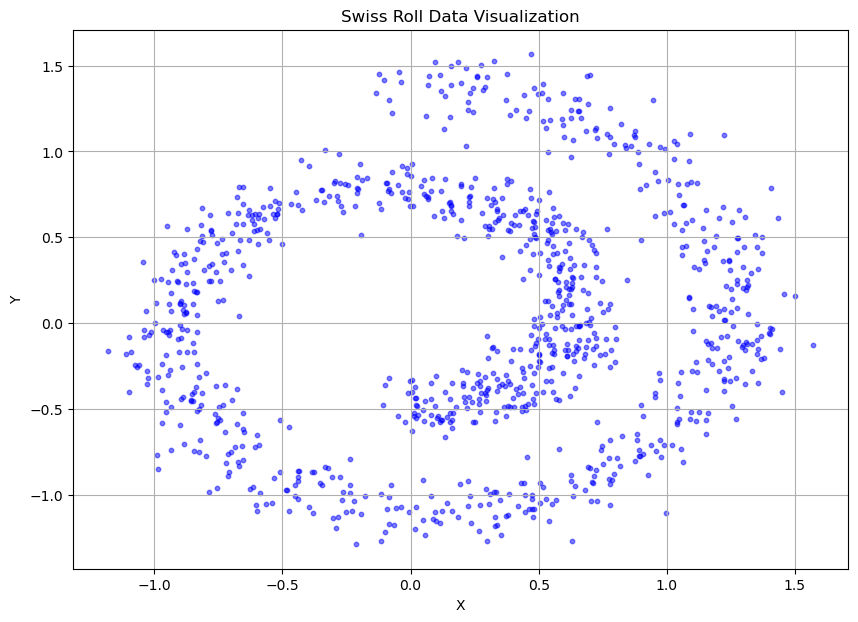

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

# 生成瑞士卷数据集的样本
def sample_batch(size, noise=1.0):
    x, _ = make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

# 从输入张量中提取指定时间步的元素
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

# 生成beta调度表，用于控制每个时间步的噪声强度
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

# 可视化瑞士卷数据
def visualize_swiss_roll():
    data = sample_batch(1000)
    plt.figure(figsize=(10, 7))
    plt.scatter(data[:, 0], data[:, 1], c='blue', marker='o', s=10, alpha=0.5)
    plt.title('Swiss Roll Data Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

# 可视化瑞士卷数据
visualize_swiss_roll()

In [14]:
# ConditionalLinear 是一个自定义线性层，包含时间步嵌入，用于条件化输入特征
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)  # 线性变换层
        self.embed = nn.Embedding(n_steps, num_out)  # 时间步嵌入层
        self.embed.weight.data.uniform_()  # 初始化嵌入权重

    def forward(self, x, y):
        out = self.lin(x)  # 对输入特征进行线性变换
        gamma = self.embed(y)  # 获取时间步嵌入向量
        # gamma 的维度是 [batch_size, num_out]，通过 view(-1, self.num_out) 保持这个维度
        # 逐元素乘法使得线性变换的输出根据时间步进行条件化
        out = gamma.view(-1, self.num_out) * out
        return out

# ConditionalModel 是一个使用 ConditionalLinear 层的神经网络模型
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)  # 第一层条件线性层
        self.lin2 = ConditionalLinear(128, 128, n_steps)  # 第二层条件线性层
        self.lin3 = ConditionalLinear(128, 128, n_steps)  # 第三层条件线性层
        self.lin4 = nn.Linear(128, 2)  # 最后一层普通线性层
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))  # 通过第一层并使用 softplus 激活函数
        x = F.softplus(self.lin2(x, y))  # 通过第二层并使用 softplus 激活函数
        x = F.softplus(self.lin3(x, y))  # 通过第三层并使用 softplus 激活函数
        return self.lin4(x)  # 输出最终结果

EMA 

指数移动平均 Exponential Moving Average (EMA)是常常用到的训练 trick，不同于直接更新模型权重，首先保留一些之前的权重，然后基于当前权重和之前的权重得到更新的权重均值，这里参考[DDIM](https://github.com/ermongroup/ddim) 的代码：

In [15]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

训练过程定义如下：

tensor(0.6020, grad_fn=<MeanBackward0>)
tensor(0.7829, grad_fn=<MeanBackward0>)
tensor(0.9490, grad_fn=<MeanBackward0>)
tensor(0.5602, grad_fn=<MeanBackward0>)
tensor(0.7271, grad_fn=<MeanBackward0>)
tensor(1.0588, grad_fn=<MeanBackward0>)
tensor(0.4761, grad_fn=<MeanBackward0>)
tensor(0.7699, grad_fn=<MeanBackward0>)
tensor(0.7214, grad_fn=<MeanBackward0>)
tensor(0.7370, grad_fn=<MeanBackward0>)


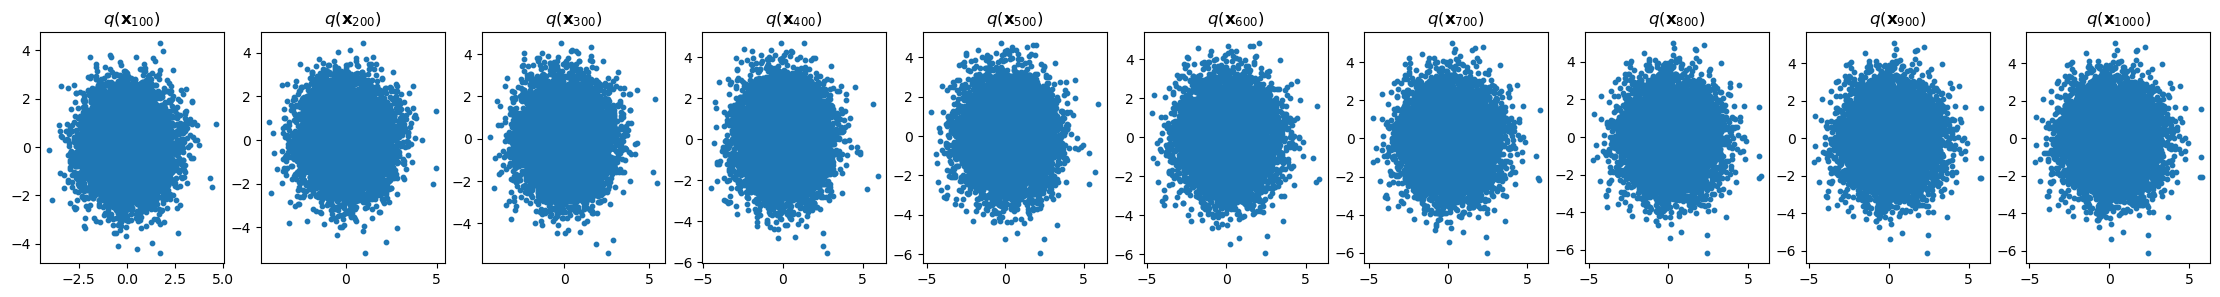

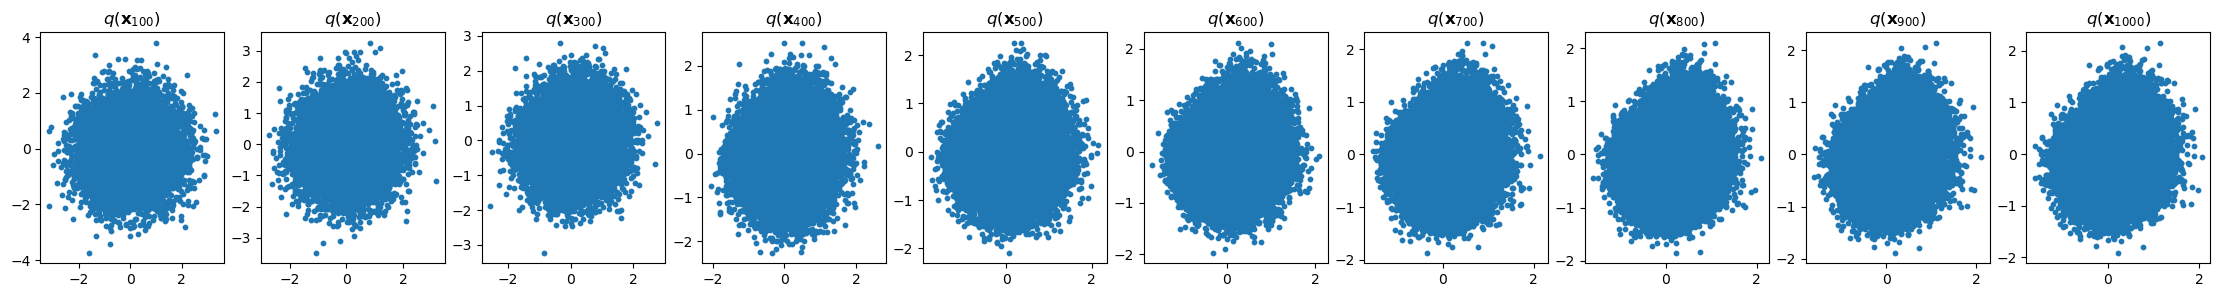

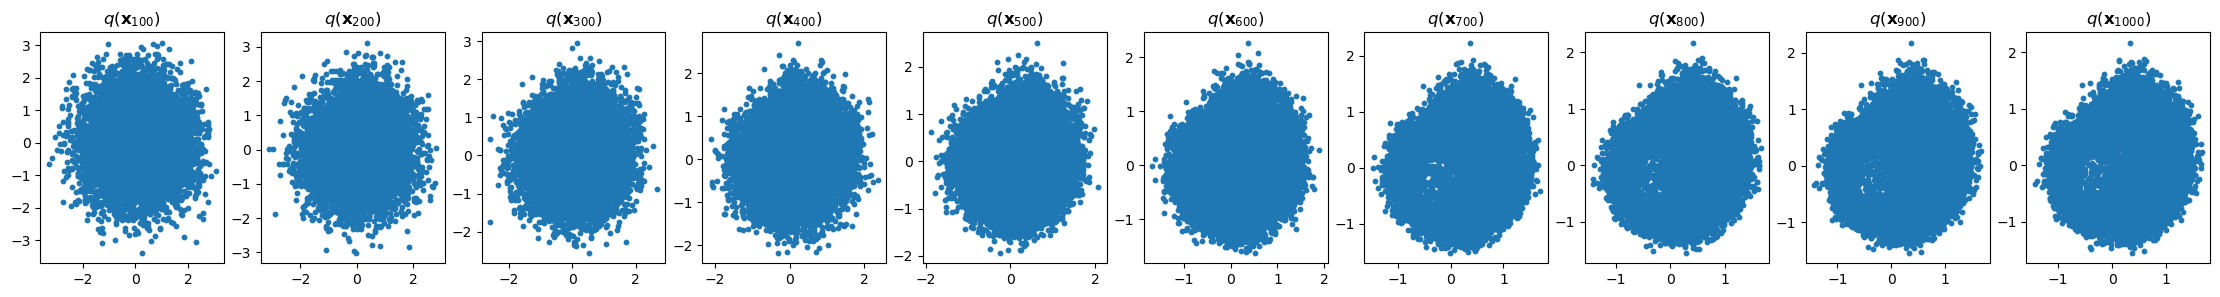

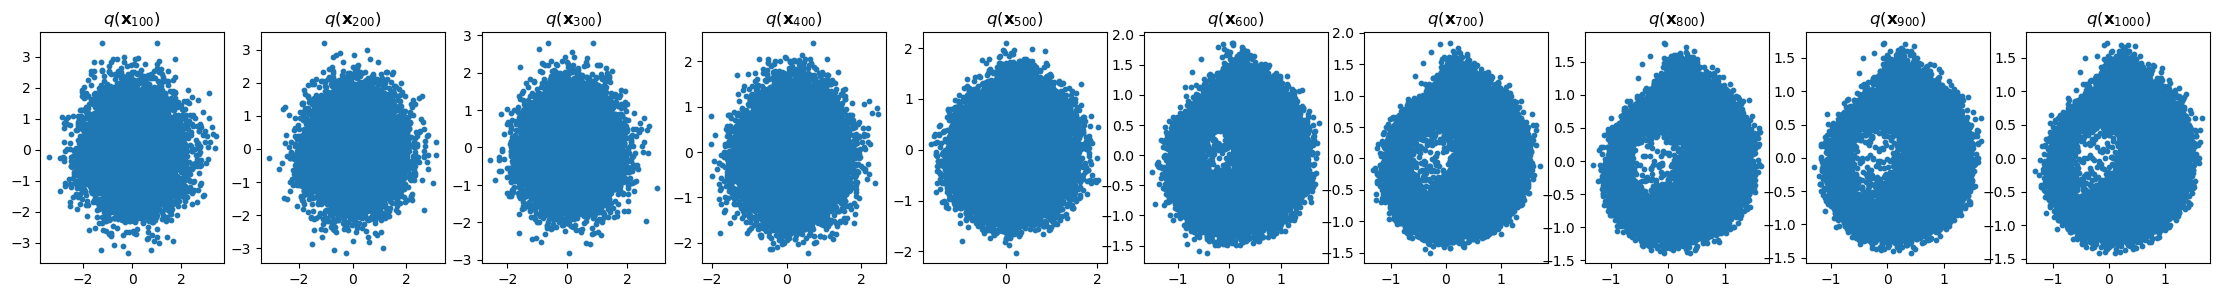

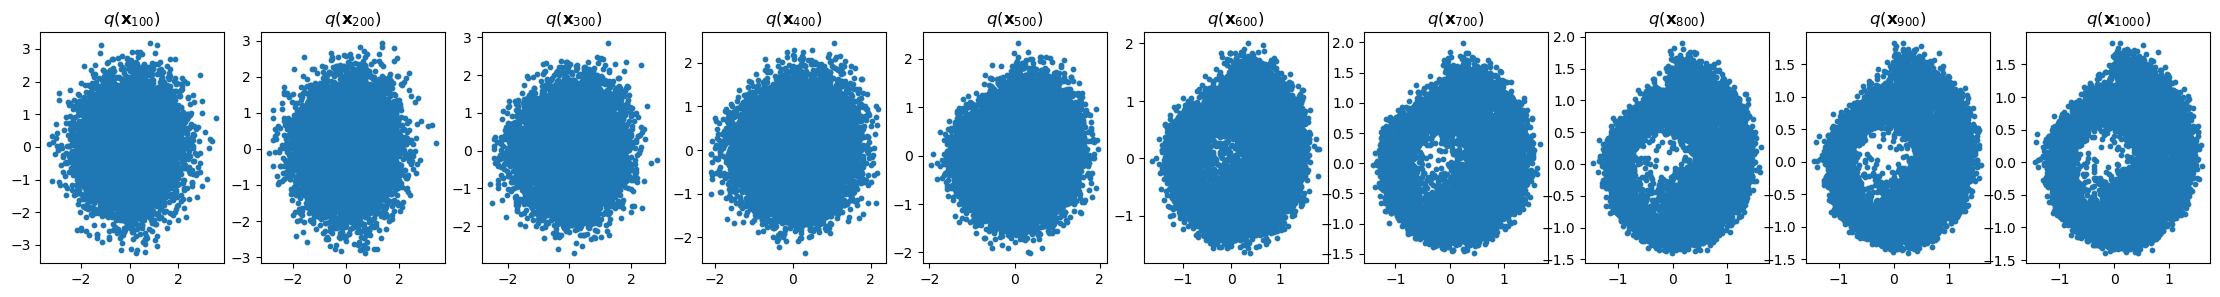

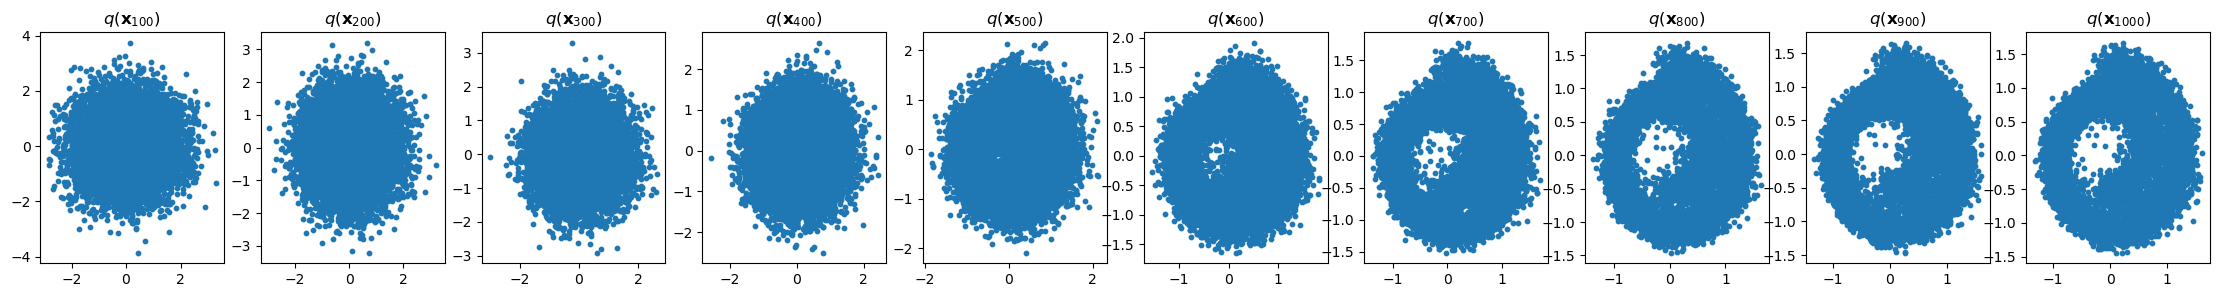

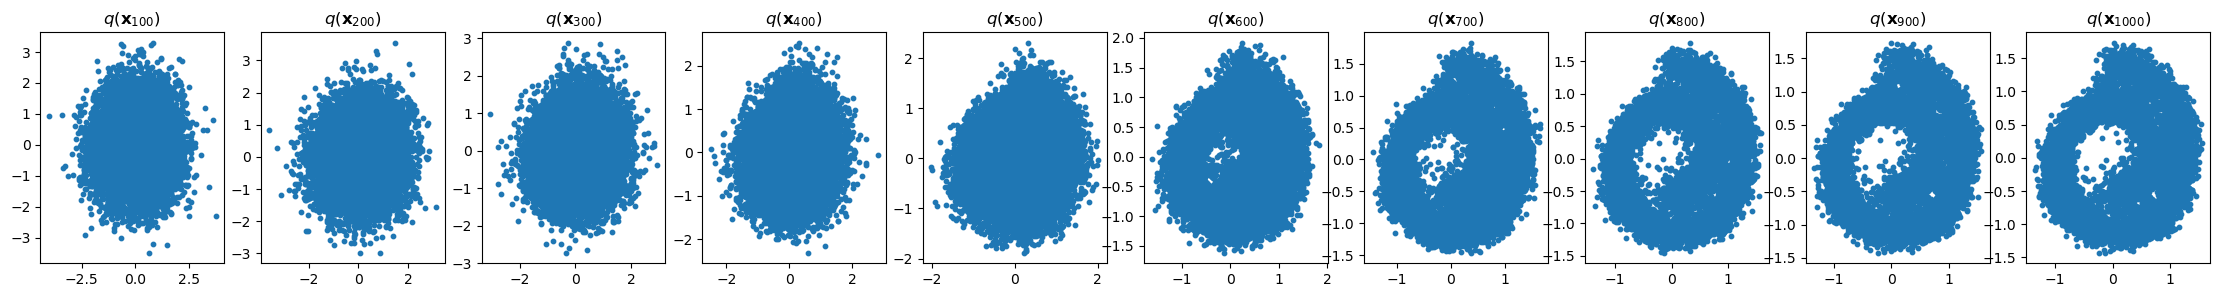

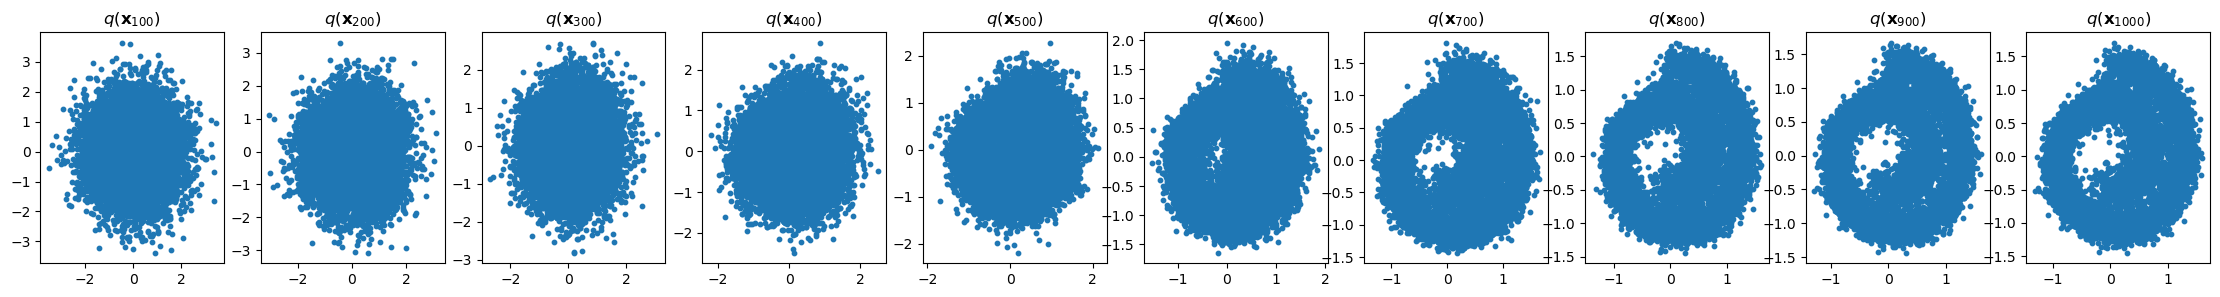

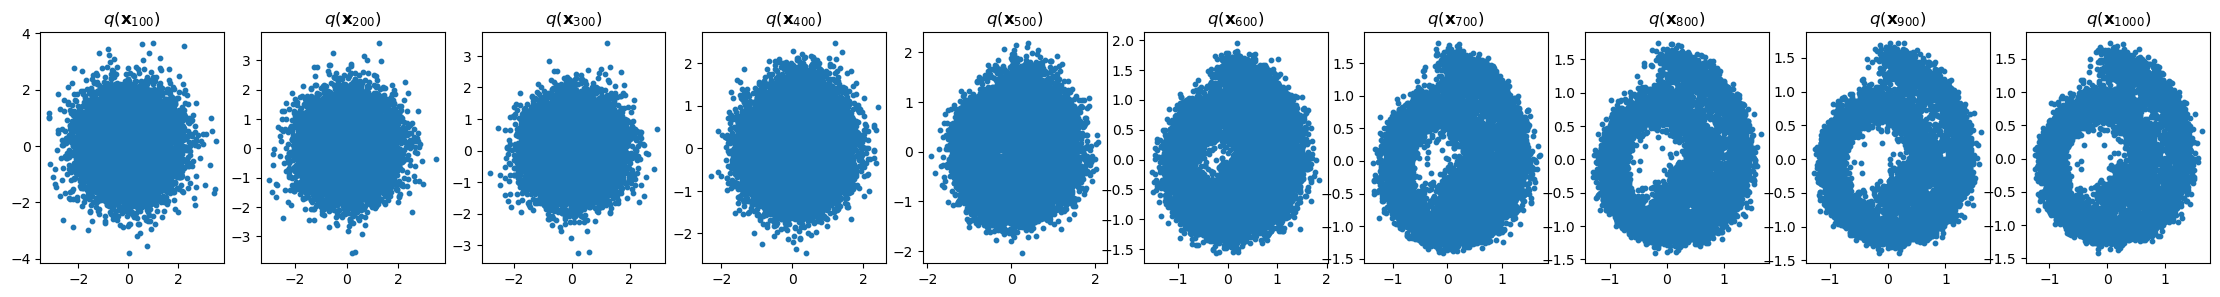

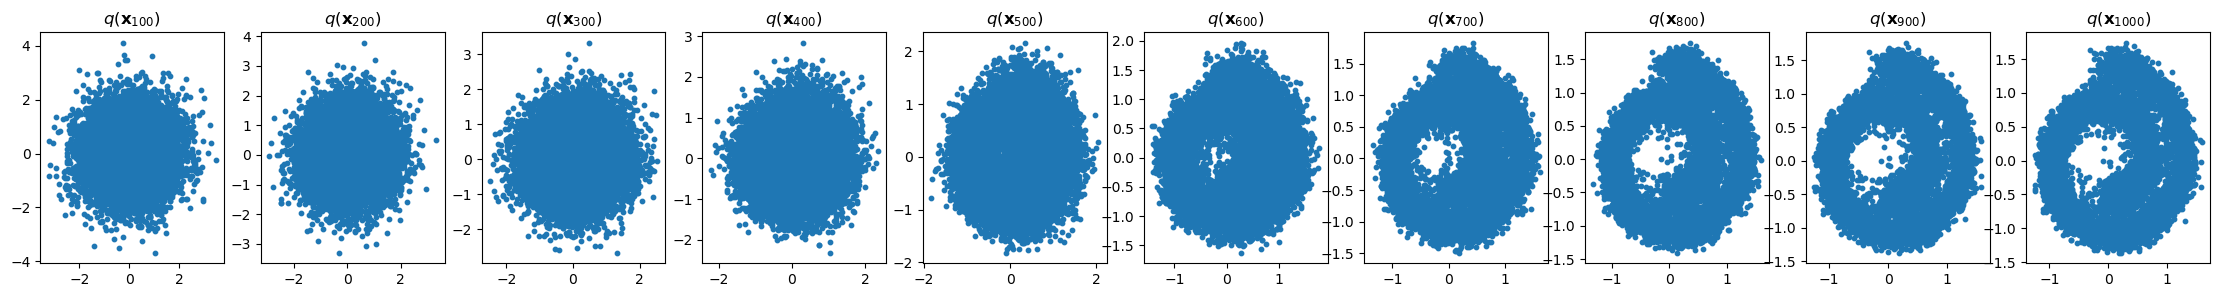

In [16]:
def p_sample_loop(model, shape,n_steps,alphas):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i,alphas)
        x_seq.append(cur_x)
    return x_seq

n_steps = 100

betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

# data
data = sample_batch(10**4).T
dataset = torch.tensor(data.T).float()

# create EMA model
model = ConditionalModel(n_steps)
ema = EMA(0.9)
ema.register(model)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# batch size
batch_size = 128

# train
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,n_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
        
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape,n_steps,alphas)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* <a href="https://d2l.ai/chapter_recurrent-neural-networks/index.html">Dive Into Deep Learning - Recurrent Neural Networks</a>
* <a href="https://atcold.github.io/pytorch-Deep-Learning/en/week12/12-1/">DS-GA 1008 - NYU CENTER FOR DATA SCIENCE - Deep Sequence Modeling</a>
* <a href="https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html">Text classification with the torchtext library
</a>
* <a href="https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/">Tricks For Training Transformers - Borealis AI - P. Xu, S. Prince</a>
* <a href="https://taldatech.github.io">Tal Daniel</a>